# Importing Libraries

In [4]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score
import time
import pickle 
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading Files

In [5]:
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')
federal_rates = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
corridor_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
news_data = pd.read_csv('../InputData/news.csv')
stock_prices = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
vix_indices = pd.read_csv('../InputData/vix_index.csv')
vixeem_indices = pd.read_csv('../InputData/vxeem_index.csv')
gold_prices = pd.read_csv('../InputData/intraday_gold.csv')
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')

In [ ]:
gold_prices_target.head()

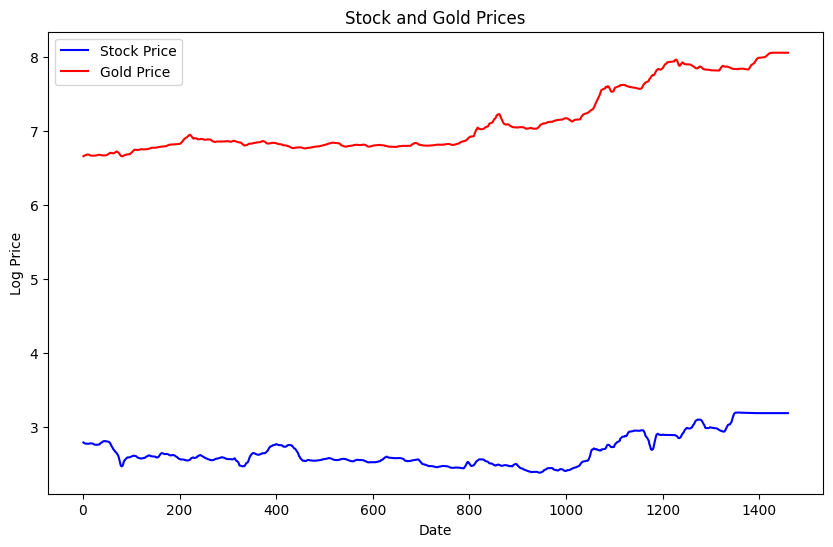

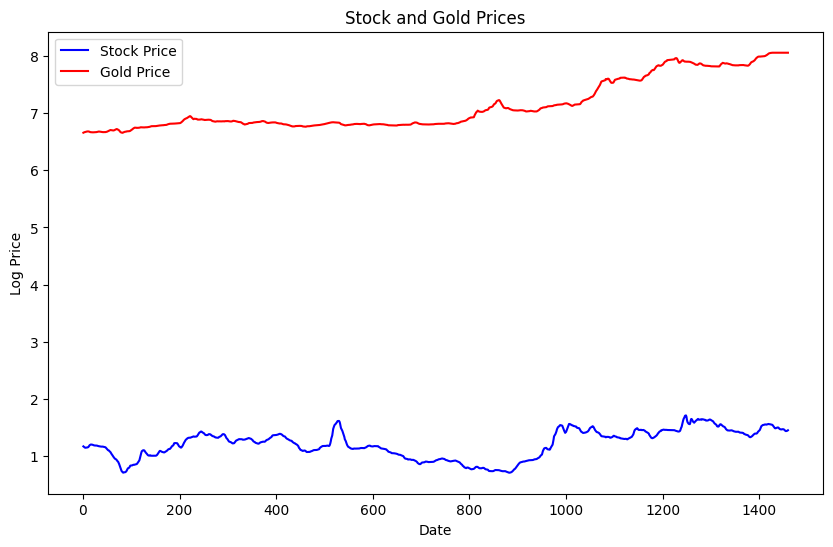

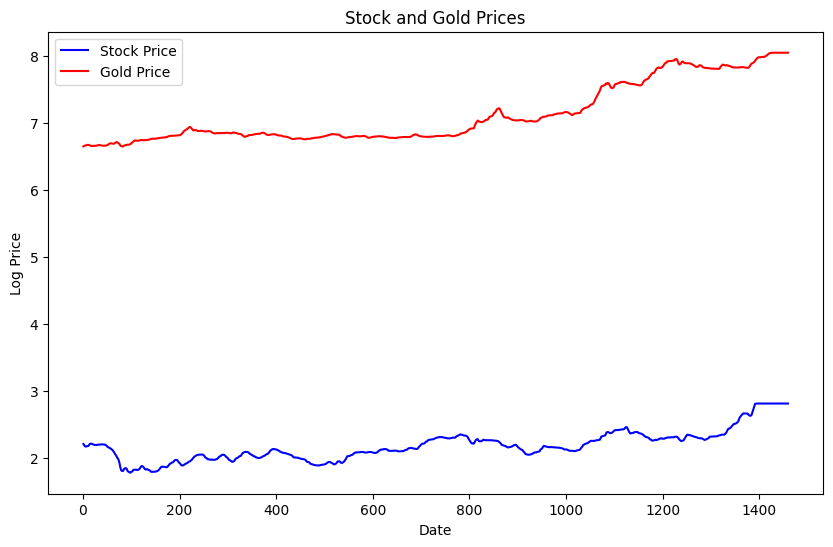

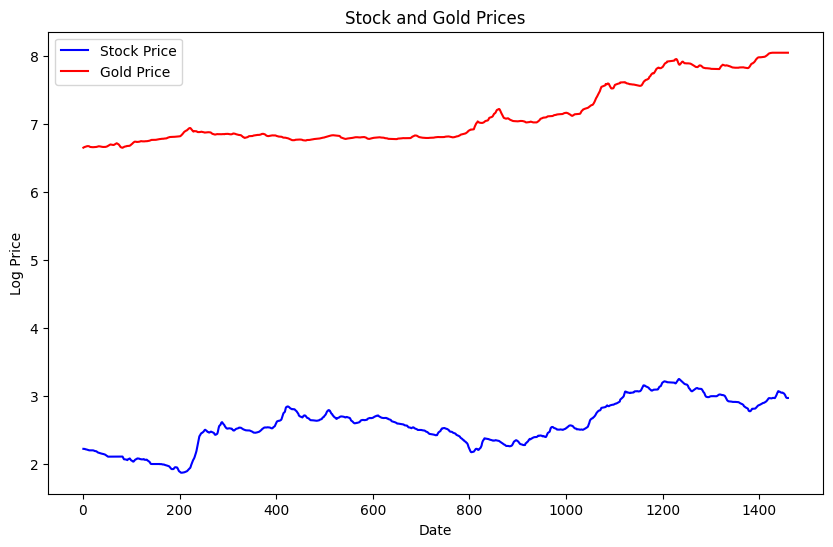

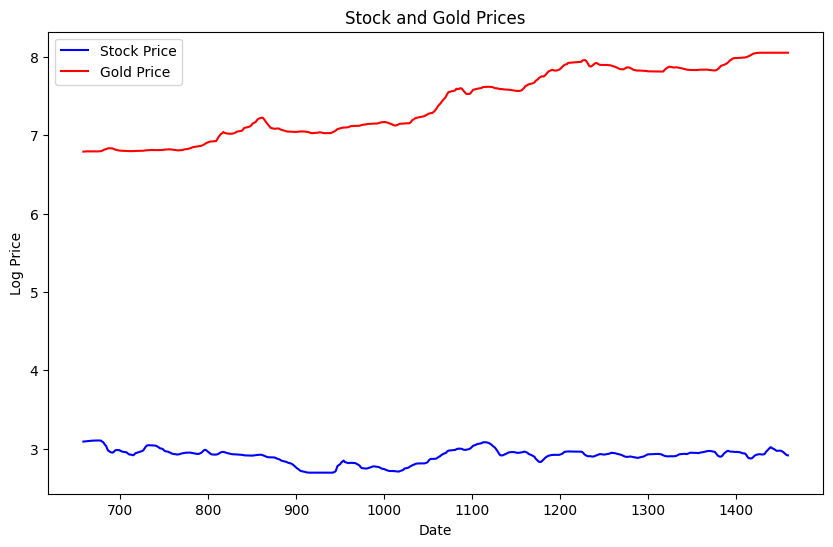

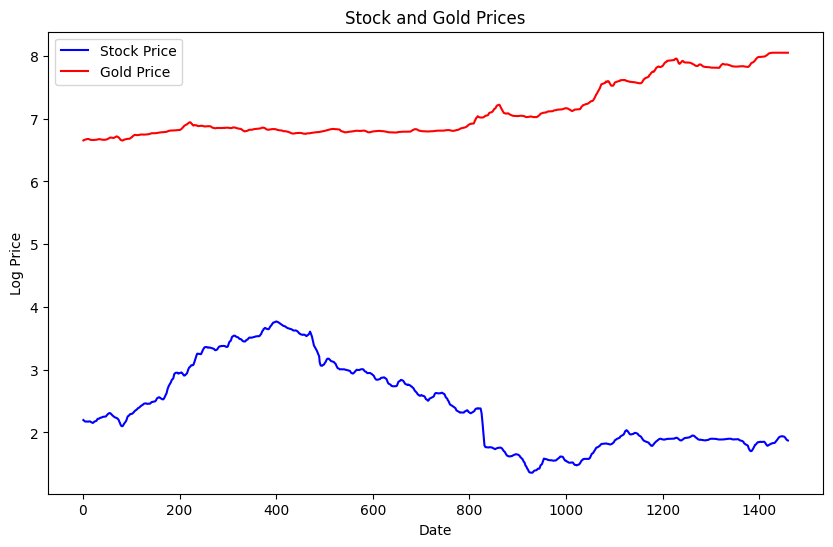

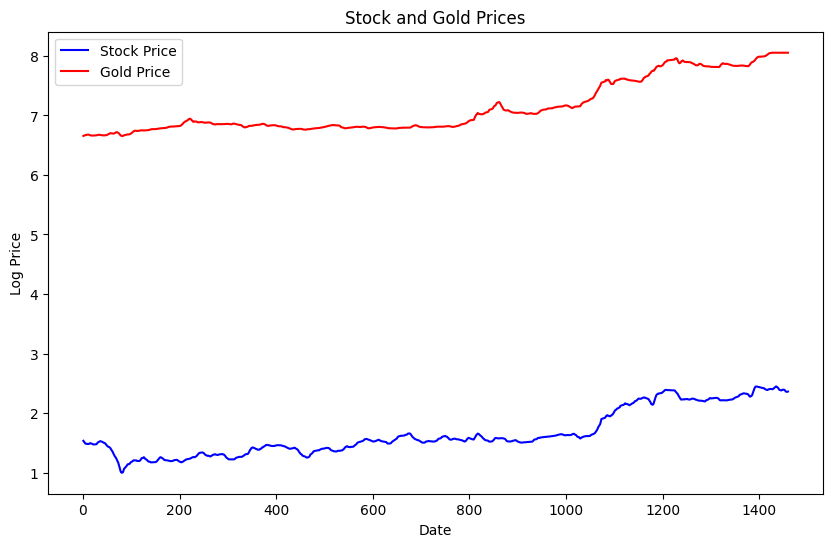

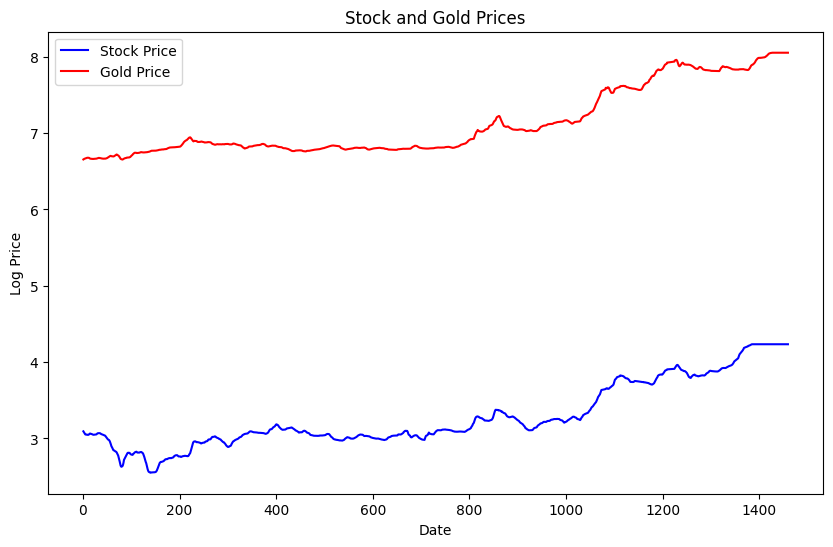

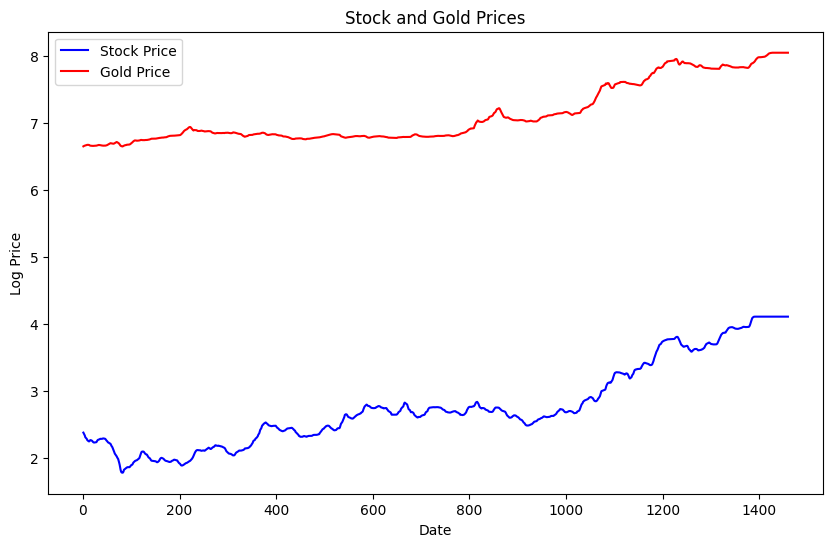

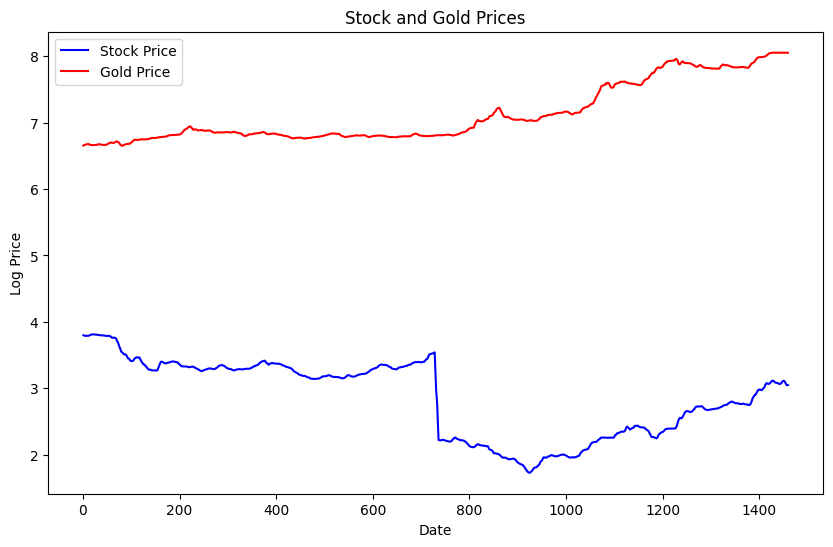

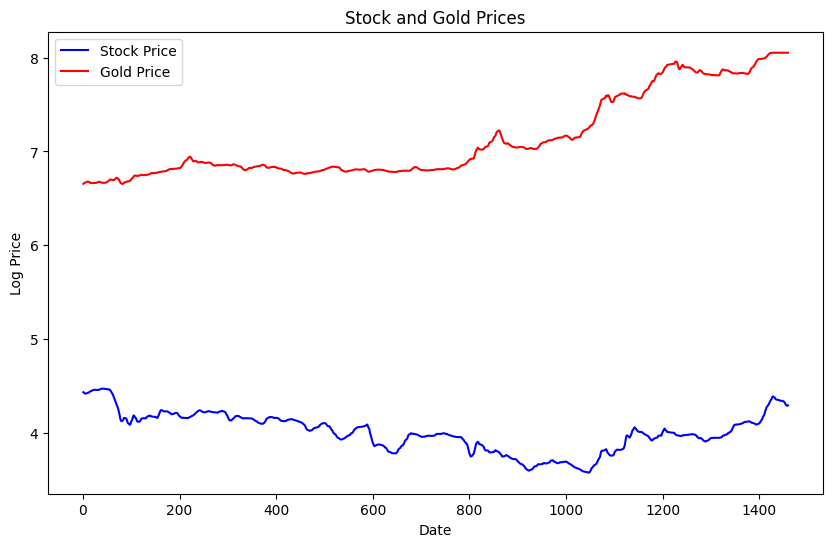

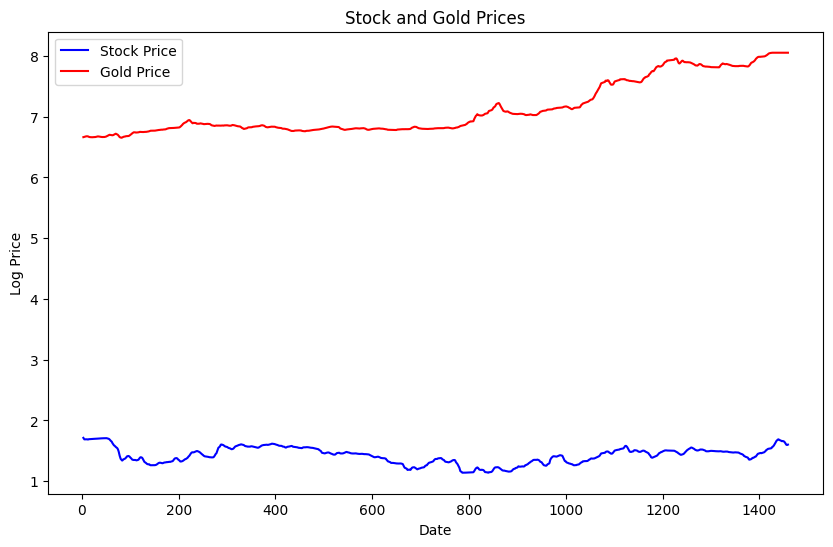

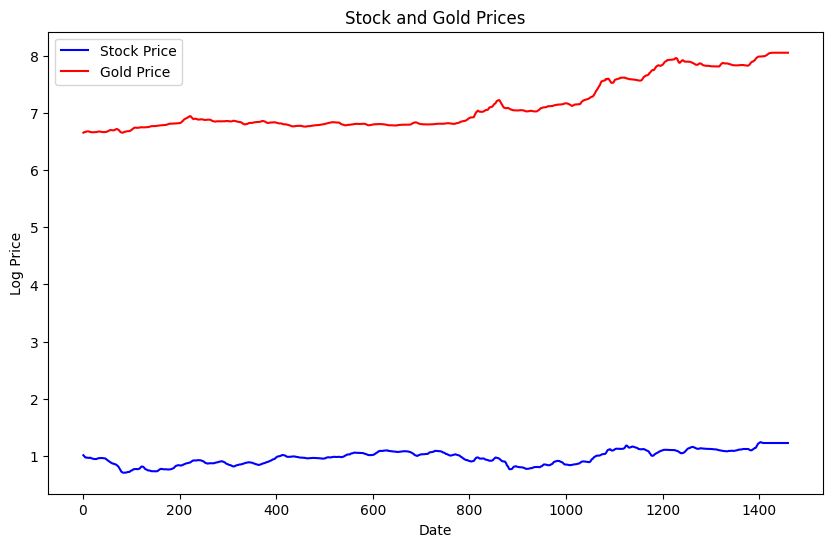

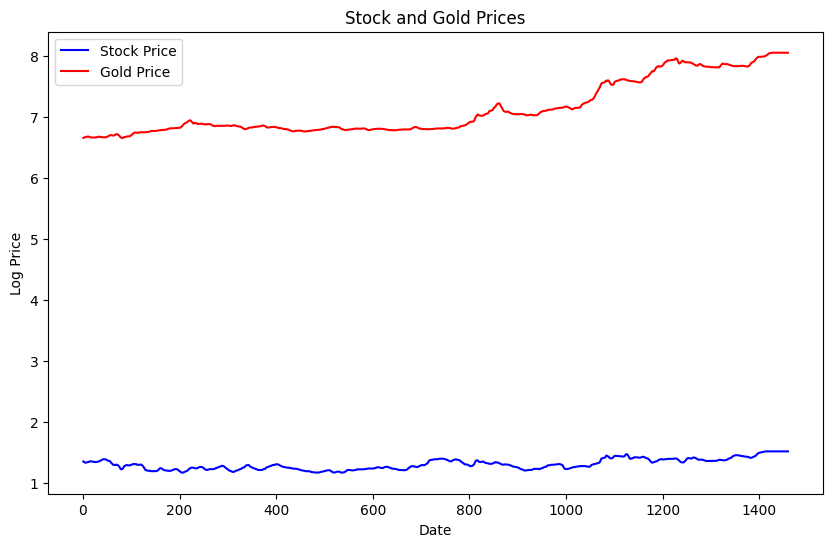

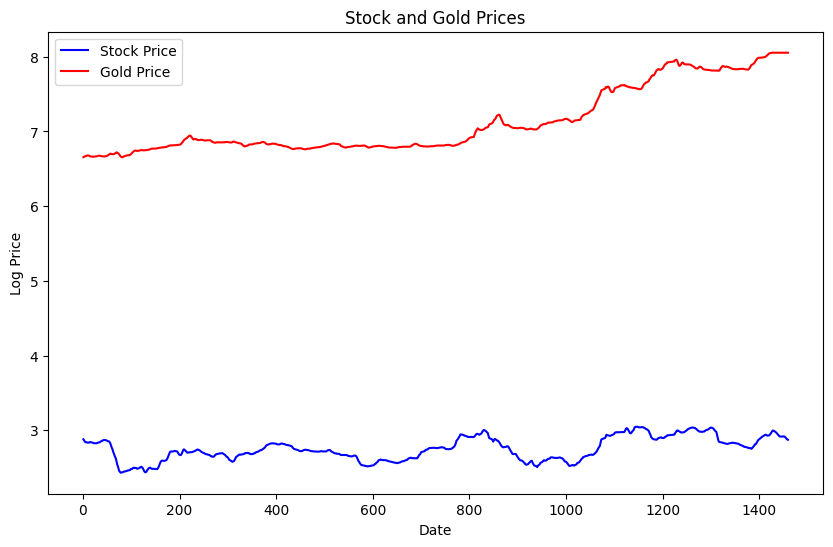

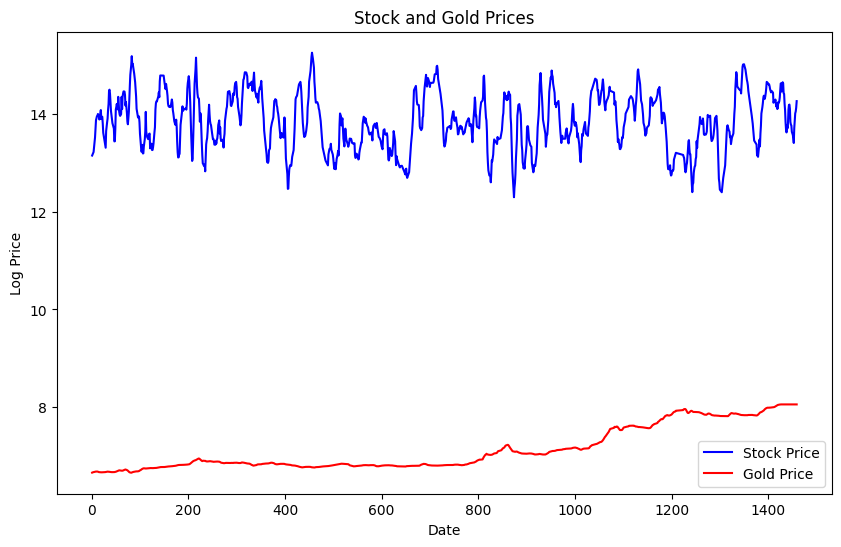

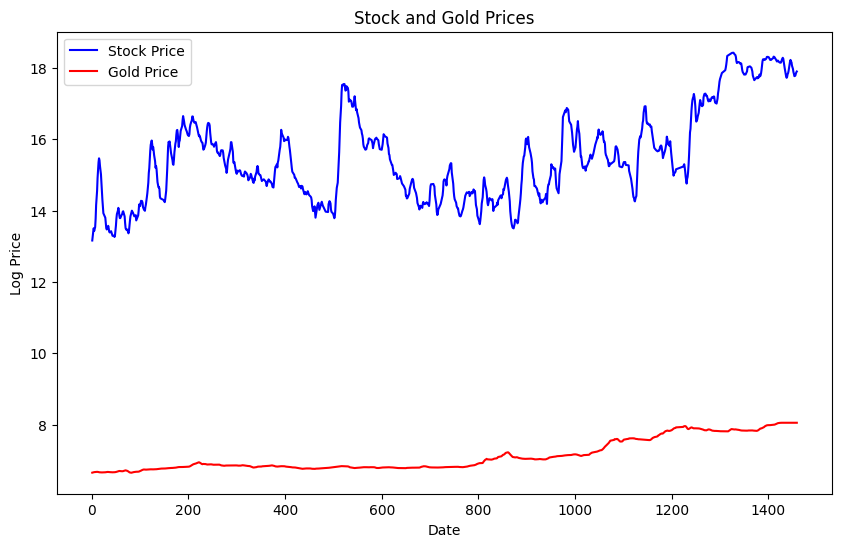

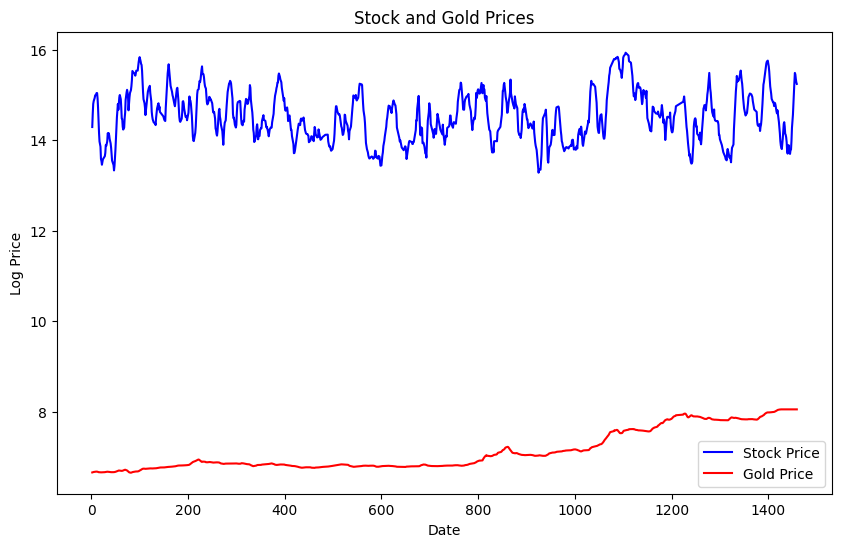

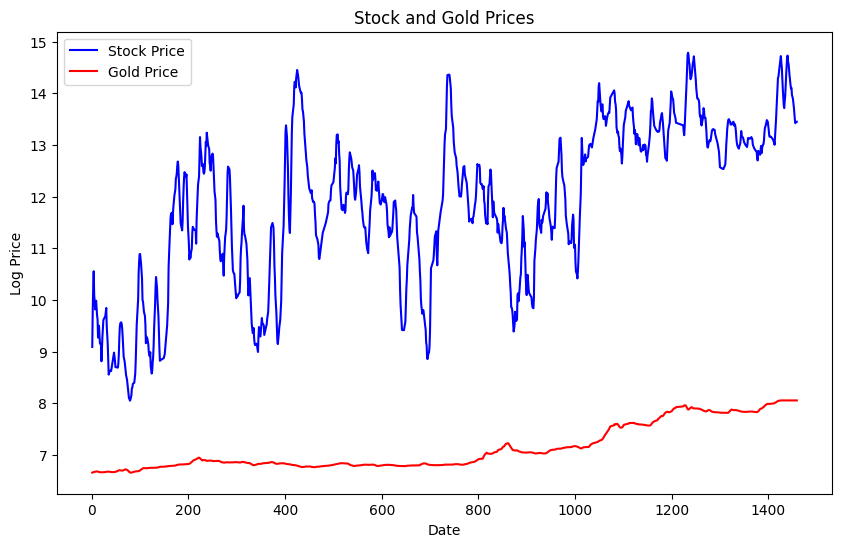

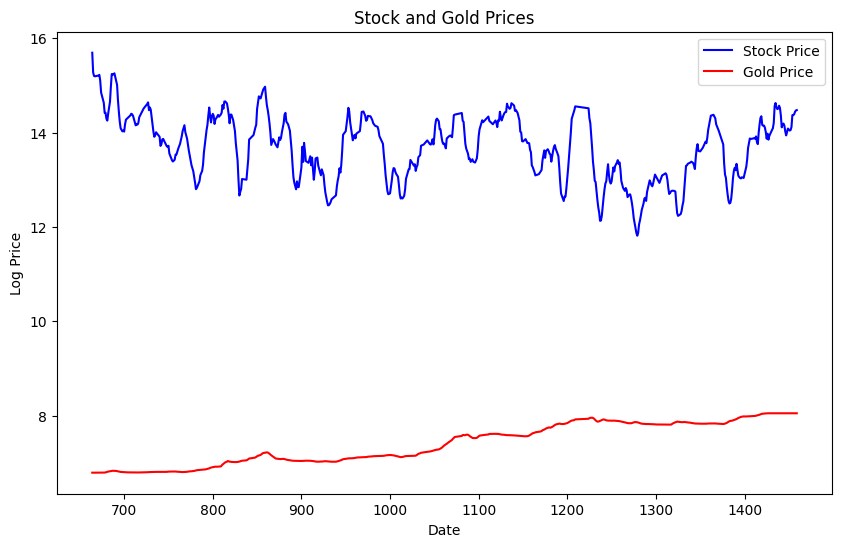

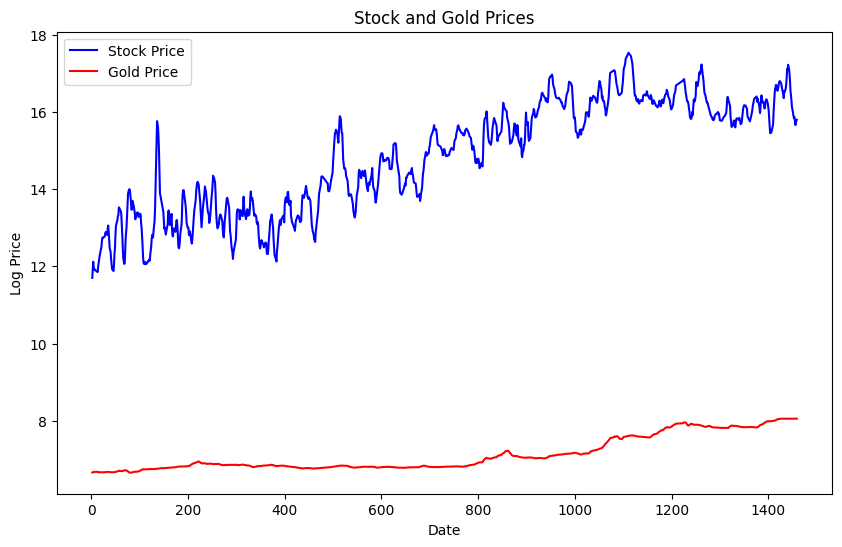

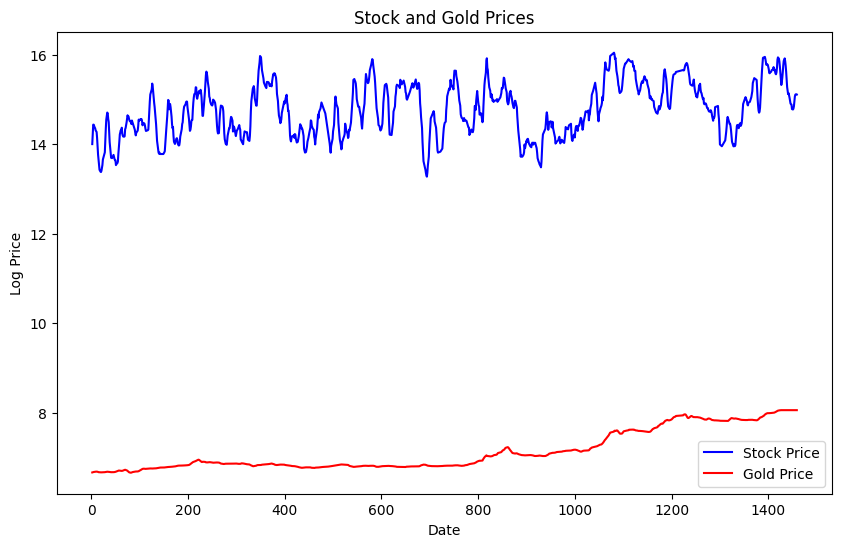

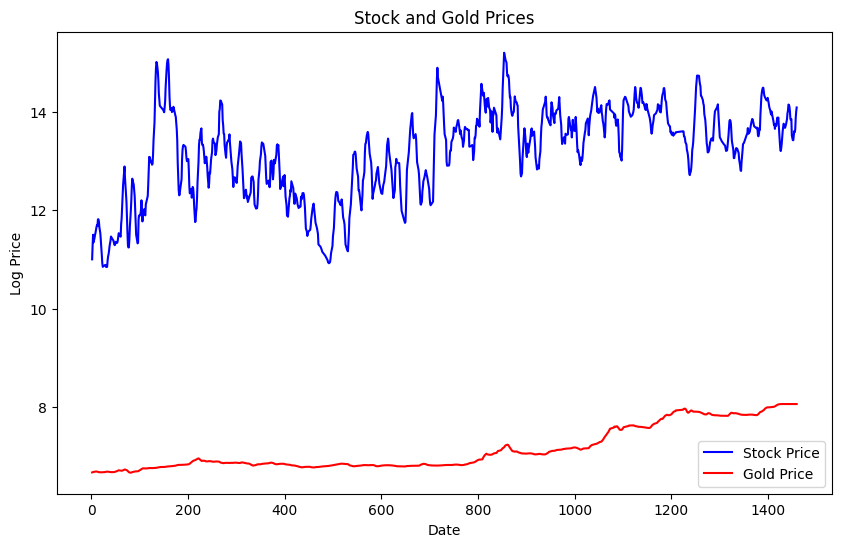

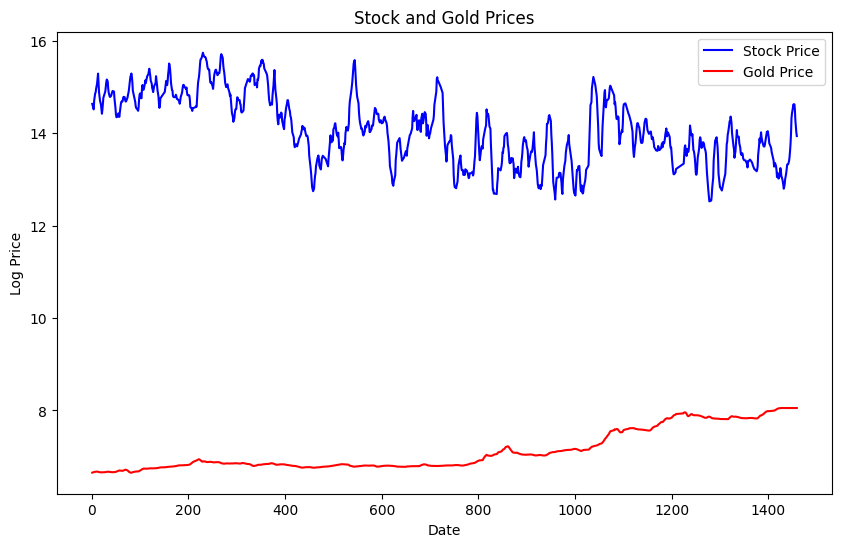

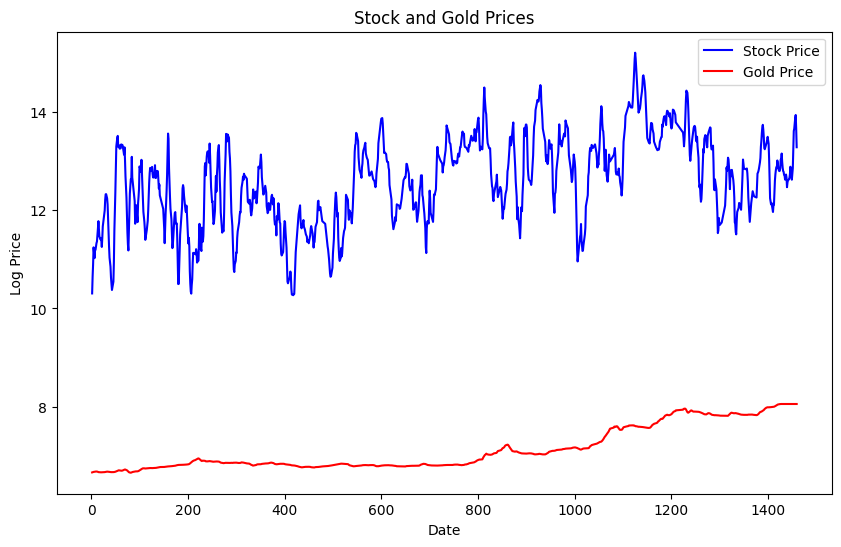

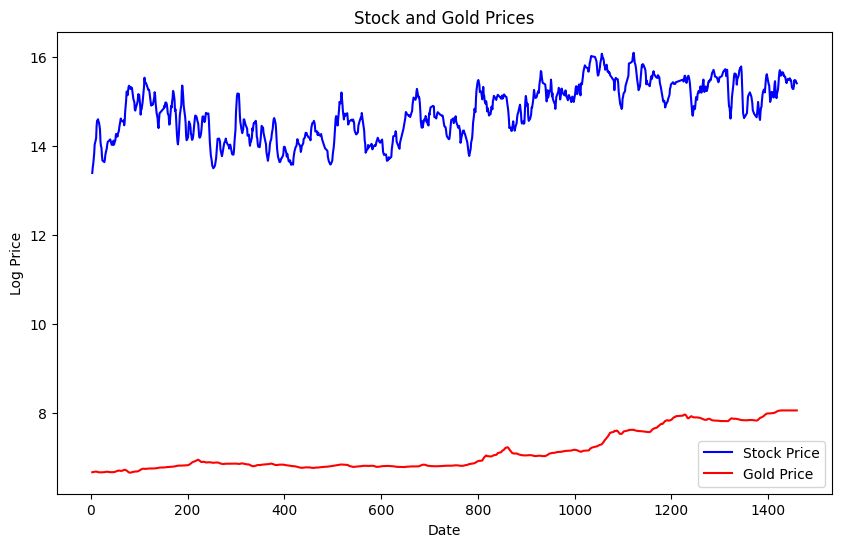

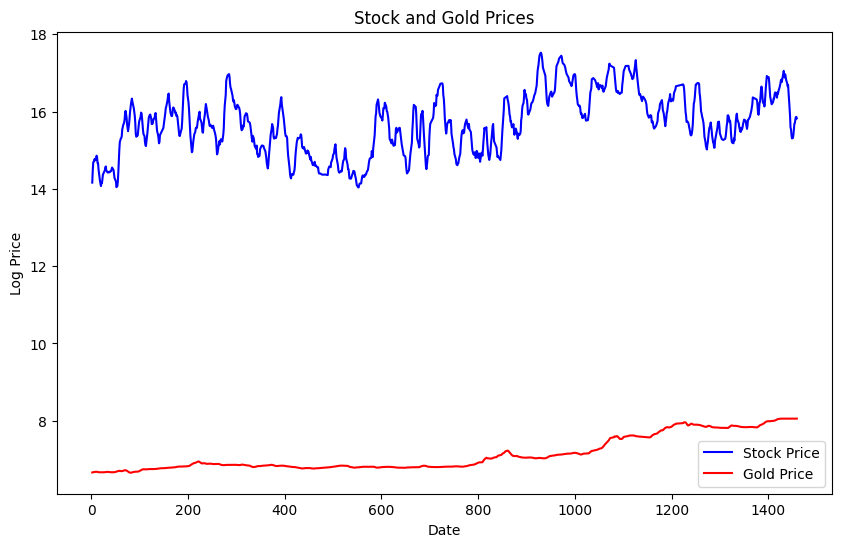

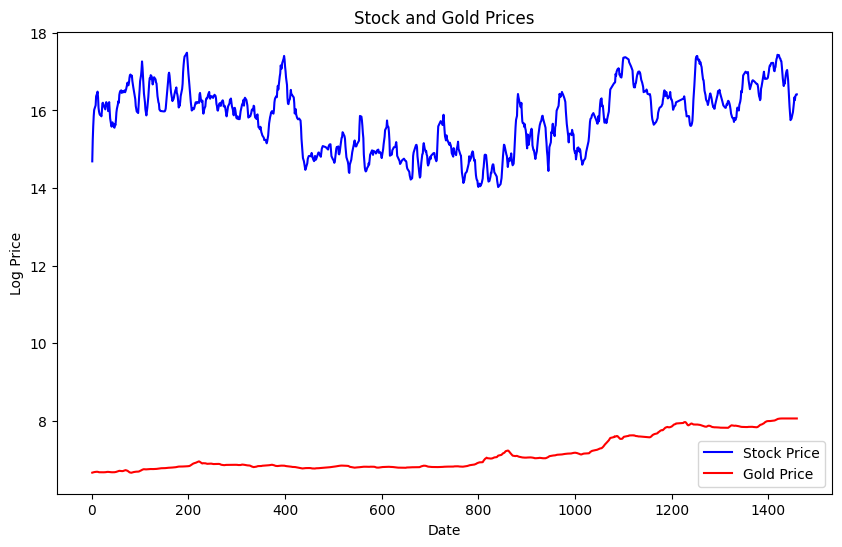

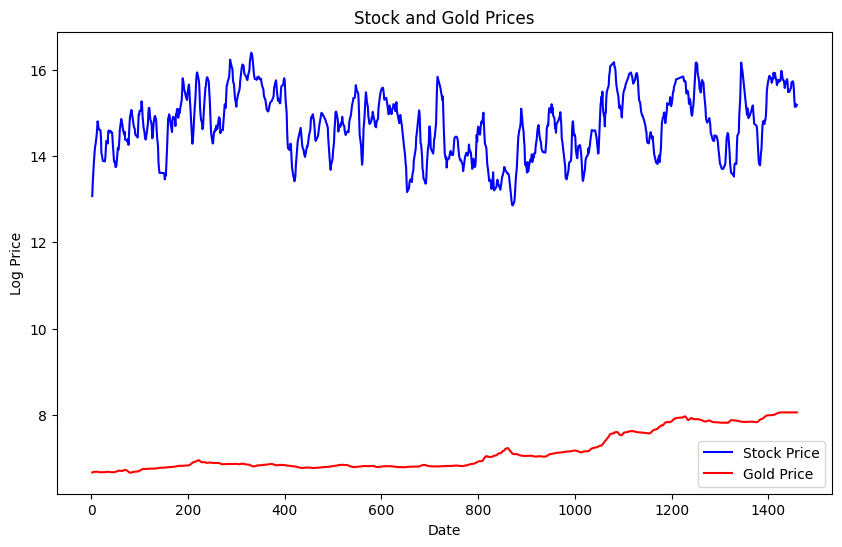

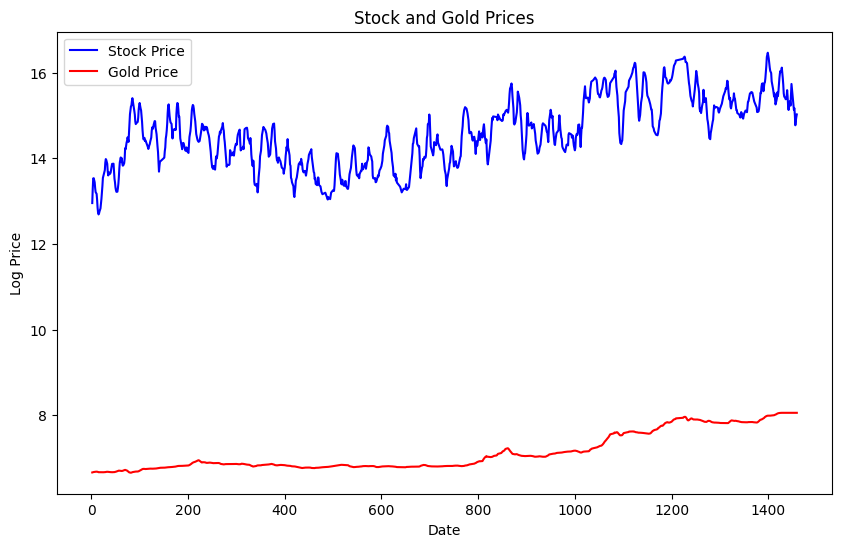

In [59]:
merged_data_list = []

# Convert the column to Date Object
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.date

gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'] , errors='coerce')

# Convert the column to Date Object
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

#Convert Column to Date Object
gold_daily = gold_prices.groupby('Date').last().reset_index()

for stock_prices_column in stock_prices.columns:
    if stock_prices_column == 'Date':
        continue
    
    #Get Start and End Date relative to each dataset
    start_date = max(stock_prices['Date'].min(), gold_daily['Date'].min())
    end_date = min(stock_prices['Date'].max(), gold_daily['Date'].max())
    
    #Filter the data based on the start and end date
    stock_prices = stock_prices[(stock_prices['Date'] >= start_date) & (stock_prices['Date'] <= end_date)]
    gold_daily = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]
    
    
    #Merge the data
    merged_data = pd.merge(stock_prices, gold_daily, on='Date', how='inner')
    merged_data.interpolate(method='linear', inplace=True)
    
    #Create Log Columns
    merged_data['Log_Stock_Price'] = np.log(merged_data[stock_prices_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)
    
    # merged_data['Log_Stock_Price'] = merged_data[stock_prices_column]
    # merged_data['Log_Gold_Price'] = merged_data['24K']
    
    #Calculate the mean and standard deviation of the gold price
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    
    #Calculate the threshold values for the gold price
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    
    #Calculate the mean and standard deviation of the stock price
    mean_stock_price = merged_data['Log_Stock_Price'].mean()
    std_stock_price = merged_data['Log_Stock_Price'].std()
    
    #Calculate the threshold values for the stock price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price
    
    #Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')
    
    #Create a mask for the outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['Log_Stock_Price'] < threshold_lower_stock) | (merged_data['Log_Stock_Price'] > threshold_upper_stock)
    
    #Set the outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'Log_Stock_Price'] = np.nan
    
    #Interpolate the missing values
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['Log_Stock_Price'] = merged_data['Log_Stock_Price'].interpolate(method='linear')
    
    merged_data['Smoothed_Log_Stock_Price'] = merged_data['Log_Stock_Price'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()
    
    filtered_data = merged_data[['Date', 'Smoothed_Log_Stock_Price', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()
    filtered_data.interpolate(method='linear', inplace=True)
    filtered_data = filtered_data.dropna(subset=['Smoothed_Log_Stock_Price', 'Smoothed_Log_Gold_Price'])
    

    
    merged_data_list.append(filtered_data)
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['Smoothed_Log_Stock_Price'], label='Stock Price', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Stock and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()
    

In [61]:
model_list = []
for merged_data_for_model in merged_data_list:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['Smoothed_Log_Stock_Price'] = merged_data_for_model['Smoothed_Log_Stock_Price']
    model = Prophet()
    model.add_regressor('Smoothed_Log_Stock_Price')
    model.fit(df)
    model_list.append(model)

    

17:06:53 - cmdstanpy - INFO - Chain [1] start processing
17:06:54 - cmdstanpy - INFO - Chain [1] done processing
17:06:54 - cmdstanpy - INFO - Chain [1] start processing
17:06:55 - cmdstanpy - INFO - Chain [1] done processing
17:06:55 - cmdstanpy - INFO - Chain [1] start processing
17:06:56 - cmdstanpy - INFO - Chain [1] done processing
17:06:56 - cmdstanpy - INFO - Chain [1] start processing
17:06:57 - cmdstanpy - INFO - Chain [1] done processing
17:06:57 - cmdstanpy - INFO - Chain [1] start processing
17:06:58 - cmdstanpy - INFO - Chain [1] done processing
17:06:58 - cmdstanpy - INFO - Chain [1] start processing
17:06:59 - cmdstanpy - INFO - Chain [1] done processing
17:06:59 - cmdstanpy - INFO - Chain [1] start processing
17:07:00 - cmdstanpy - INFO - Chain [1] done processing
17:07:00 - cmdstanpy - INFO - Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing
17:07:01 - cmdstanpy - INFO - Chain [1] start processing
17:07:02 - cmdstanpy - INFO - Chain [1]

In [55]:
predictions = []
for i, model in enumerate(model_list):    
    future = model.make_future_dataframe(periods=290)
    last_known_stock_price = merged_data_list[i]['Smoothed_Log_Stock_Price'].iloc[-1]
    future['Smoothed_Log_Stock_Price'] = last_known_stock_price
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions.append(pred)
    
predictions

[            Date  Predicted_Gold_Price
 0     2020-01-02            757.443467
 1     2020-01-03            760.521005
 2     2020-01-04            762.108778
 3     2020-01-05            763.987552
 4     2020-01-06            765.465876
 ...          ...                   ...
 1744  2024-10-11           4739.720114
 1745  2024-10-12           4758.575841
 1746  2024-10-13           4780.344442
 1747  2024-10-14           4800.671021
 1748  2024-10-15           4823.126790
 
 [1749 rows x 2 columns],
             Date  Predicted_Gold_Price
 0     2020-01-02            775.394404
 1     2020-01-03            778.620960
 2     2020-01-04            780.335938
 3     2020-01-05            782.343766
 4     2020-01-06            783.876433
 ...          ...                   ...
 1744  2024-10-11           4708.211049
 1745  2024-10-12           4726.902746
 1746  2024-10-13           4748.525889
 1747  2024-10-14           4768.381880
 1748  2024-10-15           4790.123924
 
 [1749 row

In [ ]:
gold_prices_target['Date'] = pd.to_datetime(gold_prices_target['date'])
gold_prices_target['Date'] = gold_prices_target['Date'].dt.date
gold_prices_target.drop(columns=['date'], inplace=True)
gold_prices_target.set_index('Date' , inplace=True)

In [ ]:
crude_oil_prices.head()

In [ ]:
crude_oil_prices['Date'] = pd.to_datetime(crude_oil_prices['Date'])
crude_oil_prices['Date'] = crude_oil_prices['Date'].dt.date
crude_oil_prices.set_index('Date' , inplace=True)

In [ ]:
features_df = pd.DataFrame(crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1)
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]
X

# EDA

In [ ]:
gold_prices_target.describe()

In [ ]:
px.line(gold_prices_target)

In [ ]:
crude_oil_prices.describe()

In [ ]:
px.line(crude_oil_prices)

# Feature Selection

In [ ]:
features_df = pd.merge(gold_prices_target, (crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1), on='Date', how='left')
features_df.fillna(0, inplace=True)
features_df

In [ ]:
px.line(features_df)

# Modelling

In [ ]:
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]  
y = features_df['pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Validation

In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mda = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred)))

y_test_buckets = pd.qcut(y_test, 4, labels=False) 
y_pred_buckets = pd.qcut(y_pred, 4, labels=False)

f1 = f1_score(y_test_buckets, y_pred_buckets, average='weighted')

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Directional Accuracy: {mda}')
print(f'Bucketized F1 Score: {f1}')
print(f'Inference Time (seconds): {inference_time}')


## Visualize the results

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(features_df.index, y, label='Actual Target Variable', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Target Variable', color='red')
plt.title('Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# Saving Model

In [ ]:
with open('../Pickles/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Loading Model

In [ ]:
with open('../Pickles/linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
output_df = pd.DataFrame({
    'date': X_test.index,
    'prediction': y_pred.flatten()
})
output_df